In [2]:
!pip install tensorflow-gpu==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [1]:
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils
directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "classification_paths", "Intel_image_dataset_path")

Extracting : 100%|██████████| 13318/13318 [00:33<00:00, 402.95it/s]


1. First of all run this code in Google Colab as if you try to run one epoch it takes 20 minutes to run.
2. Run the above code to check which version of cuda has been installed in the backend of google servers.
3. Them check this website "https://www.tensorflow.org/install/source" for  compatibility of CUDA with tensorflow 
4. As when I am running this code it's version is 11.1 so that is the reason I have installed tensorflow-gpu version 2.4
yet the latsest version is 2.9.1

In [4]:
from tensorflow.keras.layers import Add,Dense,Activation,ZeroPadding2D,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, Dense, Input, InputLayer, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB5
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set(font_scale=1.4)
from  matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.utils import shuffle
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np 
import shutil
import random
import cv2 
import os

In [5]:
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import log_loss, accuracy_score 
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
from tqdm import tqdm
import pandas as pd
import itertools
import inspect
import random
import sys

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [8]:
class_names = ['buildings', 'forest', 'glacier', 'mountain',  'sea', 'street']
class_names_label = {class_name:i for (i, class_name) in enumerate(class_names)}
nb_c1asses = len(class_names)
print(class_names_label)
IMAGE_SIZE = (150, 150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [9]:
import cv2
import imghdr

In [10]:
rm -rf `find -type d -name .ipynb_checkpoints`

The above line of code is worked when it is running on colab or linux

The below code is use for loading the data in form of images and labels, one can also try tensorflow.keras.preprocessing.image.ImageDataGenerator it decreases the space memory but it also decreases the accuracy drastically.

In [11]:
def load_data():
    DIRECTORY = '/content/archive'
    CATEGORY = ['seg_train','seg_test']
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {} ".format(category))
        for folder in os.listdir(path):
            print("/ "+folder)
            label = class_names_label[folder]
            #label = class_names_label[folder]
            print(label)
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                print(img_path)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        
        output.append((images, labels))
    return output

This is how the archive directory looks
 <img src="directory.png"> 
 so try to add or upload the data in this format only in google colab.
 

In [12]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading train 
/ mountain
3
/content/train/mountain/9896.jpg
/content/train/mountain/11032.jpg
/content/train/mountain/12081.jpg
/content/train/mountain/11864.jpg
/content/train/mountain/11544.jpg
/content/train/mountain/10174.jpg
/content/train/mountain/11637.jpg
/content/train/mountain/11732.jpg
/content/train/mountain/10824.jpg
/content/train/mountain/10837.jpg
/content/train/mountain/8629.jpg
/content/train/mountain/11491.jpg
/content/train/mountain/10552.jpg
/content/train/mountain/10031.jpg
/content/train/mountain/11215.jpg
/content/train/mountain/12066.jpg
/content/train/mountain/11049.jpg
/content/train/mountain/9399.jpg
/content/train/mountain/11562.jpg
/content/train/mountain/12195.jpg
/content/train/mountain/8564.jpg
/content/train/mountain/8436.jpg
/content/train/mountain/9088.jpg
/content/train/mountain/9120.jpg
/content/train/mountain/8831.jpg
/content/train/mountain/12117.jpg
/content/train/mountain/8484.jpg
/content/train/mountain/11677.jpg
/content/train/mountain/9643.

In [13]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [14]:
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(150,150,3),classes=6)
#The reason behind choosing the EfficientNetB5 as the base model is when you try to run model for classification on pretrained models it takes chunks of memory from the dataset a
#and tries to give best accuracy. You can try to make your own models so that you learn first how convolution and other neural network works.

115269632/115263384 [==============================] - 4s 0us/step


In [15]:
model= Sequential()
model.add(base_model) 
model.add(Dropout(.2))
model.add(Flatten()) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
#Here you can add more layers to get high accuracy but increasing more layer causes overfitting.
model.add(Dense(6,activation=('softmax')))
#Defining the parameters
adam = Adam(learning_rate=0.00001)
#Take learning rate as small as posiible but as small you then you have to run more than 100 epochs
#Compiling the model
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 5, 5, 2048)        28513527  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7

In [16]:
%%timeit -n1 -r1 
#with tf.device('/CPU:0'):
history = model.fit(train_images, train_labels, batch_size=64, epochs=100, validation_split = 0.2)

Epoch 1/100
37/37 [==============================] - 75s 1s/step - loss: 1.8947 - accuracy: 0.2106 - val_loss: 3.1270 - val_accuracy: 0.1652
Epoch 2/100
37/37 [==============================] - 39s 1s/step - loss: 1.3059 - accuracy: 0.5036 - val_loss: 3.3110 - val_accuracy: 0.1962
Epoch 3/100
37/37 [==============================] - 39s 1s/step - loss: 0.9956 - accuracy: 0.6549 - val_loss: 3.8034 - val_accuracy: 0.1601
Epoch 4/100
37/37 [==============================] - 39s 1s/step - loss: 0.7733 - accuracy: 0.7542 - val_loss: 3.4450 - val_accuracy: 0.1601
Epoch 5/100
37/37 [==============================] - 39s 1s/step - loss: 0.6148 - accuracy: 0.7963 - val_loss: 3.2627 - val_accuracy: 0.1652
Epoch 6/100
37/37 [==============================] - 39s 1s/step - loss: 0.5373 - accuracy: 0.8121 - val_loss: 3.4281 - val_accuracy: 0.1652
Epoch 7/100
37/37 [==============================] - 39s 1s/step - loss: 0.4497 - accuracy: 0.8556 - val_loss: 3.9533 - val_accuracy: 0.1687
Epoch 8/100
3

In [17]:
def plot_accuracy_loss(history):

    #Plot the accuracy and the loss during the training of the nn.

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

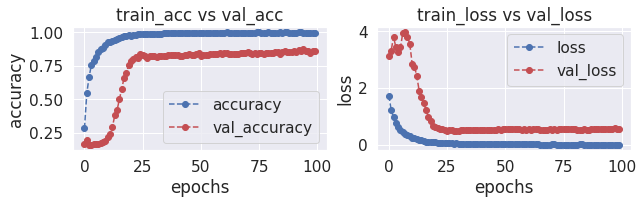

In [18]:
plot_accuracy_loss(model.history)

In [19]:
test_loss = model.evaluate(test_images, test_labels)

4/4 [==============================] - 2s 401ms/step - loss: 0.7568 - accuracy: 0.8333


In [20]:
from sklearn.metrics import confusion_matrix , classification_report
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

print("Classification Report: \n", classification_report(test_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.95      1.00      0.98        20
           2       0.76      0.80      0.78        20
           3       0.65      0.75      0.70        20
           4       0.88      0.70      0.78        20
           5       0.94      0.85      0.89        20

    accuracy                           0.83       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.83      0.83       120



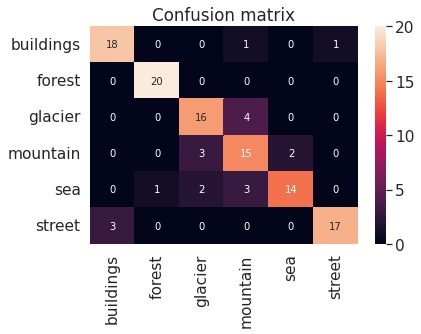

In [21]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Original label is street and predicted label is street


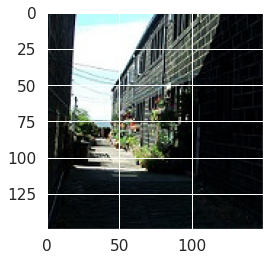

In [23]:
 
image_number = 10
 
# display the image
plt.imshow(test_images[image_number])
 
# load the image in an array
n = np.array(test_images[image_number])
 
# reshape it
p = n.reshape(1, 150, 150, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = class_names[model.predict(p).argmax()]
 
# load the original label
original_label = class_names[test_labels[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [24]:
def image_name(str):
  img = cv2.imread(str)
  plt.imshow(img)
  plt.show()
  image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMAGE_SIZE) 
  image = np.array(image, dtype = 'float32')
  image = image.reshape(1, 150, 150, 3)
  image = image / 255.0
  predicted_label = class_names[model.predict(image).argmax()]
  print(predicted_label)

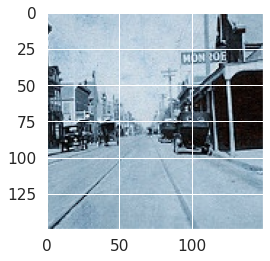

street


In [26]:
image_name('14.jpg')

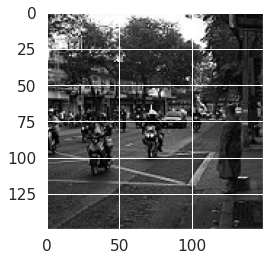

street


In [27]:
image_name('3.jpg')